In [83]:
from datasets import load_dataset
import cv2
import albumentations
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.transforms import v2
from tqdm import tqdm

In [84]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [85]:
ds = load_dataset("mrm8488/ImageNet1K-val", split="train")

ds

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['image', 'label'],
    num_rows: 50000
})

In [86]:
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomResizedCrop(size=(128, 128), antialias=True),
        v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


def transform(examples):
    examples["pixel_values"] = [transforms(image) for image in examples["image"]]
    del examples["image"]
    return examples


ds.set_transform(transform)
train_test = ds.train_test_split(test_size=0.1)

trainloader = torch.utils.data.DataLoader(
    train_test["train"], batch_size=64, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    train_test["test"], batch_size=64, shuffle=False
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.2885156].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..1.8731159].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6726604..2.605142].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..1.9235382].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3986644..2.64

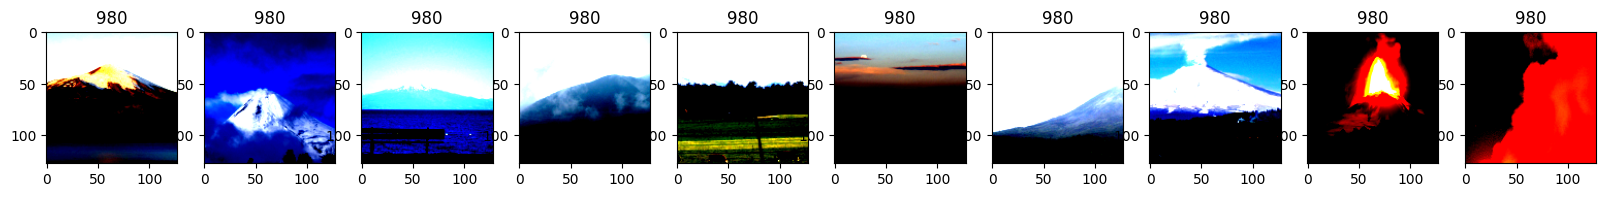

In [87]:
def show_in_row(images, labels):
    n = len(labels)
    plt.figure(figsize=(20, 6))
    for idx, item in enumerate(zip(images, labels)):
        plt.subplot(1, n, idx + 1)
        plt.imshow(item[0].permute(1, 2, 0).numpy())
        plt.title(item[1])
    plt.show()


show_in_row(ds[49000:49010]["pixel_values"], ds[49000:49010]["label"])

In [88]:
class CNN(nn.Module):
    def __init__(self, out_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)  # 124x124x16
        self.pool = nn.MaxPool2d(2, 2)  # 62x62x16
        self.conv2 = nn.Conv2d(16, 32, 5)  # 58x58x32
        self.fc1 = nn.Linear(26912, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, out_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [89]:
cnn = CNN(1000)
cnn.to(device)

optimizer = optim.Adam(cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [90]:
def calc_corrects(model, batch):
    labels, inputs = batch.values()
    labels = labels.to(device)
    inputs = inputs.to(device)
    logits = model(inputs)

    preds = F.softmax(logits, dim=1).argmax(dim=1)
    correct = (preds == labels).sum().item()

    return correct

In [ ]:
cnn.train()
print("Training..")
for epoch in range(2):
    running_loss = 0.0
    running_corrects = 0.0
    for i, data in enumerate(tqdm(trainloader)):
        labels, inputs = data.values()
        labels = labels.to(device)
        inputs = inputs.to(device)

        with torch.autocast(device_type=device, dtype=torch.float32):
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        running_corrects += calc_corrects(cnn, data)
        if i % 150 == 149:
            print(f"Loss: {running_loss / (i + 1):.4f}")
            print(f"Accuracy: {running_corrects / (i + 1):.3f}")

cnn.eval()
print("Testing..")
running_loss = 0.0
running_corrects = 0.0

for i, data in enumerate(tqdm(testloader)):
    labels, inputs = data.values()
    labels = labels.to(device)
    inputs = inputs.to(device)

    outputs = cnn(inputs)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    running_corrects += calc_corrects(cnn, data)

print(f"Loss: {running_loss / (i + 1):.4f}")
print(f"Accuracy: {running_corrects / (i + 1):.3f}")

'Training..'

  7%|▋         | 49/704 [00:07<01:36,  6.77it/s]


KeyboardInterrupt: 